In [1]:
import os, sys

import matplotlib.pyplot as plt
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)


import numpy as np
from scipy.spatial import distance_matrix
from src.aco import Colony
from src.graph import Graph

In [2]:
def read_tsp_file(file_path: str) -> np.ndarray:
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
        num_cities = int(lines[0])
        coords = []
        for line in lines[1:num_cities+1]:
            x, y = map(float, line.split())
            coords.append([x, y])
        
        return np.array(coords)



In [3]:
def solve_test(filename):
    file_path = os.path.join('../data/', filename)
    coords = read_tsp_file(file_path)
    
    dist_matrix = distance_matrix(coords, coords)
    graph = Graph(dist_matrix, coords, eval_nn=True)
    fig, ax = plt.subplots()
    aco = Colony(
        graph=graph,
        ant_count=20,
        generations=1000,
        fig=fig,
        ax=ax,
        type='acs',
        top=5,
        alpha=1,
        beta=5,
        rho=0.1,
        q0=0.9,
        phi=0.1
    )
    best_path, best_distance = aco.run();

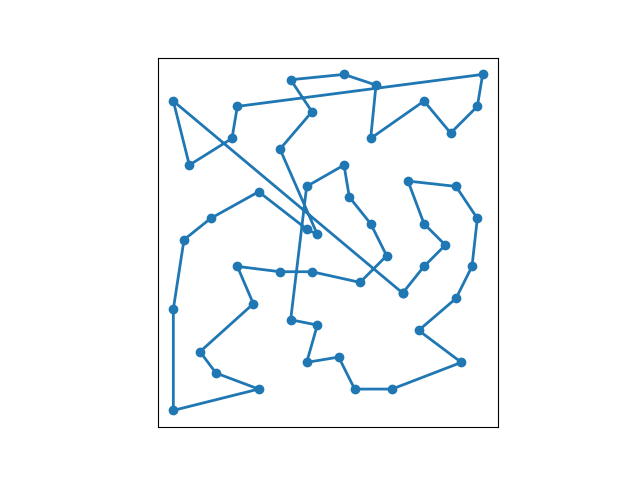

ACO Progress:   0%|                      | 4/1000 [00:23<1:39:25] , Best: 543.84

KeyboardInterrupt: 

In [4]:
%matplotlib widget
solve_test('tsp_51_1')

In [ ]:
from src.pso import PSO_TSP, TSPProblem

In [11]:
def solve_test1(filename):
    file_path = os.path.join('../data/', filename)
    coords = read_tsp_file(file_path)
    
    dist_matrix = distance_matrix(coords, coords)
    problem = TSPProblem(dist_matrix)
    pso = PSO_TSP(problem, num_particles=50, max_iter=100)
    best_route, best_distance = pso.run()
    return best_distance

In [12]:
solve_test1('tsp_51_1')

1231.3318036475964